In [18]:
import traci
import matplotlib.pyplot as plt
import json
import numpy as np
import pickle
from time import time
from os.path import exists
from os import listdir, mkdir


In [19]:
sumoBinary = "sumo"
sumoCmd = [sumoBinary, "-c", "simulacao.sumocfg"]

## Simulação com tempo fixado

In [127]:
def simulation(traffic_light_duration):
    try:
        traci.close()
    except:
        pass

    print('Starting simulation...')
    print('Traffic Light Duration:', traffic_light_duration, 'seconds')

    vehicles_list = []
    traci.start(sumoCmd)

    simulation_data = {
        'traffic_light_duration': traffic_light_duration,
        'traffic_lights': [],
        'data': [],
        'stats': {
            'step': []
        }
    }

    traffic_lights = traci.trafficlight.getIDList()

    for traffic_light in traffic_lights:

        traci.trafficlight.setProgramLogic(traffic_light, traci.trafficlight.Logic(
            programID='0',
            type=0,
            currentPhaseIndex=0,
            phases=[
                traci.trafficlight.Phase(traffic_light_duration, "GGGGGrrrrr"),
                traci.trafficlight.Phase(3, "yyyyyrrrrr"),
                traci.trafficlight.Phase(traffic_light_duration, "rrrrrGGGGG"),
                traci.trafficlight.Phase(3, "rrrrryyyyy"),
            ]
        ))

        traffic_light_data = {
            'id': traffic_light,
            'controlled_edges': [],
        }

        traffic_light_controlled_lanes = traci.trafficlight.getControlledLanes(
            traffic_light)

        traffic_light_data['controlled_lanes'] = list(
            traffic_light_controlled_lanes)

        controlled_lanes = []

        for traffic_light_controlled_lane in traffic_light_controlled_lanes:
            controlled_lanes.append(traffic_light_controlled_lane.split('_')[0])

        controlled_edges = list(set(controlled_lanes))

        for controlled_edge in controlled_edges:
            edge_data = {
                'id': controlled_edge,
                'lanes': traci.edge.getLaneNumber(controlled_edge),
            }

            traffic_light_data['controlled_edges'].append(edge_data)

        simulation_data['traffic_lights'].append(traffic_light_data)

    for step in range(24 * 3600):

        if step % 3600 == 0:
            print('Hour:', step / 3600, 'Step: {}'.format(step))

        if step == 0 * 3600:
            traci.simulation.setScale(0.6)
        elif step == 1 * 3600 or step == 2 * 3600:
            traci.simulation.setScale(0.5)
        elif step == 3 * 3600 or step == 4 * 3600:
            traci.simulation.setScale(0.4)
        elif step == 5 * 3600:
            traci.simulation.setScale(0.5)
        elif step == 6 * 3600:
            traci.simulation.setScale(0.8)
        elif step == 7 * 3600:
            traci.simulation.setScale(1.0)
        elif step == 8 * 3600:
            traci.simulation.setScale(3)
        elif step == 9 * 3600:
            traci.simulation.setScale(3.2)
        elif step == 10 * 3600:
            traci.simulation.setScale(2.8)
        elif step == 11 * 3600:
            traci.simulation.setScale(2.1)
        elif step == 12 * 3600:
            traci.simulation.setScale(2)
        elif step == 13 * 3600:
            traci.simulation.setScale(1.8)
        elif step == 14 * 3600:
            traci.simulation.setScale(1.3)
        elif step == 15 * 3600:
            traci.simulation.setScale(1.4)
        elif step == 16 * 3600:
            traci.simulation.setScale(1.8)
        elif step == 17 * 3600:
            traci.simulation.setScale(2.6)
        elif step == 18 * 3600:
            traci.simulation.setScale(2.9)
        elif step == 19 * 3600:
            traci.simulation.setScale(3.5)
        elif step == 20 * 3600:
            traci.simulation.setScale(2.7)
        elif step == 21 * 3600:
            traci.simulation.setScale(2)
        elif step == 22 * 3600:
            traci.simulation.setScale(1.3)
        elif step == 23 * 3600:
            traci.simulation.setScale(0.9)

        vehicles = traci.vehicle.getIDList()
        vehicles_list.extend(vehicles)

        simulation_data['stats']['step'].append({
            'step': step,
            'vehicles': len(vehicles),
        })

        traci.simulationStep()

        step_info = {
            'step': step,
            'traffic_lights': [],
        }

        for traffic_light in simulation_data['traffic_lights']:

            traffic_light_info = {
                'id': traffic_light['id'],
                'controlled_edges': [],
            }

            for controlled_edge in traffic_light['controlled_edges']:
                waiting_time = traci.edge.getWaitingTime(controlled_edge['id'])
                waiting_vehicle_count = traci.edge.getLastStepHaltingNumber(
                    controlled_edge['id'])

                edge_info = {
                    'id': controlled_edge['id'],
                    'waiting_time': waiting_time,
                    'waiting_vehicle_count': waiting_vehicle_count,
                    'avg_queue_length': round(waiting_vehicle_count / controlled_edge['lanes'], 2),
                }

                traffic_light_info['controlled_edges'].append(edge_info)

            step_info['traffic_lights'].append(traffic_light_info)

        simulation_data['data'].append(step_info)

    traci.close()

    simulation_data['stats']['vehicles_count'] = len(list(set(vehicles_list)))
    return simulation_data

In [ ]:
# teste
simulation_data = simulation(traffic_light_duration=42)

In [ ]:
# gerar simulações com diferentes tempos de duração do semáforo
for duration in range(15, 91):
    simulation_data = simulation(traffic_light_duration=duration)
    with open('arquivos/fixedTime_'+str(duration)+'.json', 'w') as outfile:
        outfile.write(json.dumps(simulation_data))


In [4]:
# resultado das simulações com tempos fixos
plt_data = {
    'duration': [],
    'avg_tl_total_waiting_time': [],
}

for duration in range(15, 91):
    print('duration', duration)
    with open('arquivos/fixedTime_'+str(duration)+'.json') as json_file:
        simulation_data = json.load(json_file)

        plt_data['duration'].append(duration)
        print('vehicles', simulation_data['stats']['vehicles_count'])


        traffic_lights_count = len(simulation_data['traffic_lights'])
        tl_total_waiting_time_list = []

        for step in simulation_data['data']:
            for traffic_light in step['traffic_lights']:
                for edge in traffic_light['controlled_edges']:
                    tl_total_waiting_time_list.append(edge['waiting_time'])

        avg_tl_total_waiting_time = sum(
            tl_total_waiting_time_list) / len(tl_total_waiting_time_list) * 2
        
        plt_data['avg_tl_total_waiting_time'].append(avg_tl_total_waiting_time)

        print('avg_tl_total_waiting_time', round(avg_tl_total_waiting_time, 2))


duration 15
vehicles 20000
avg_tl_total_waiting_time 5.06
duration 16
vehicles 20000
avg_tl_total_waiting_time 4.97
duration 17
vehicles 20000
avg_tl_total_waiting_time 4.79
duration 18
vehicles 20000
avg_tl_total_waiting_time 4.79
duration 19
vehicles 20000
avg_tl_total_waiting_time 4.88
duration 20
vehicles 20000
avg_tl_total_waiting_time 5.1
duration 21
vehicles 20000
avg_tl_total_waiting_time 5.34
duration 22
vehicles 20000
avg_tl_total_waiting_time 5.84
duration 23
vehicles 20000
avg_tl_total_waiting_time 6.42
duration 24
vehicles 20000
avg_tl_total_waiting_time 7.05
duration 25
vehicles 20000
avg_tl_total_waiting_time 7.68
duration 26
vehicles 20000
avg_tl_total_waiting_time 8.37
duration 27
vehicles 20000
avg_tl_total_waiting_time 8.89
duration 28
vehicles 20000
avg_tl_total_waiting_time 9.76
duration 29
vehicles 20000
avg_tl_total_waiting_time 10.57
duration 30
vehicles 20000
avg_tl_total_waiting_time 11.2
duration 31
vehicles 20000
avg_tl_total_waiting_time 11.91
duration 32
v

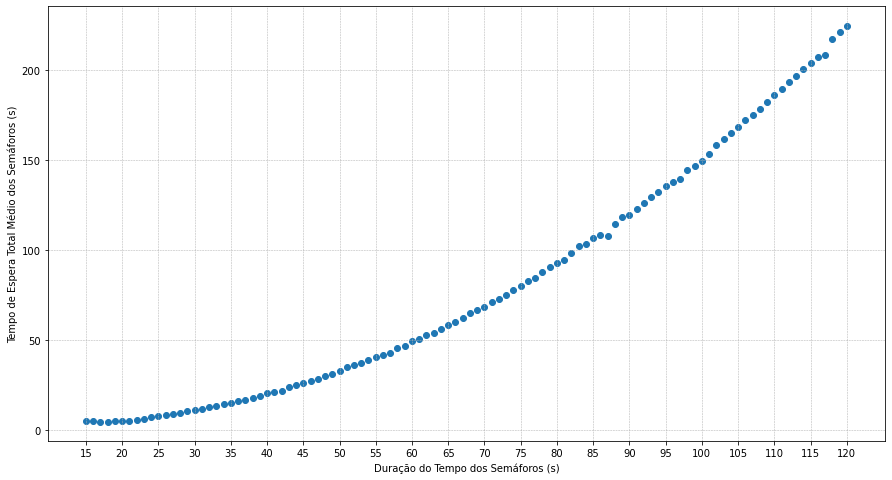

In [8]:
plt.figure(figsize=(15, 8))
plt.xlabel('Duração do Tempo dos Semáforos (s)')
plt.ylabel('Tempo de Espera Total Médio dos Semáforos (s)')
plt.scatter(plt_data['duration'], plt_data['avg_tl_total_waiting_time'])
plt.grid(linestyle='--', linewidth=0.5)
plt.xticks(range(15, 91, 5))
plt.show()

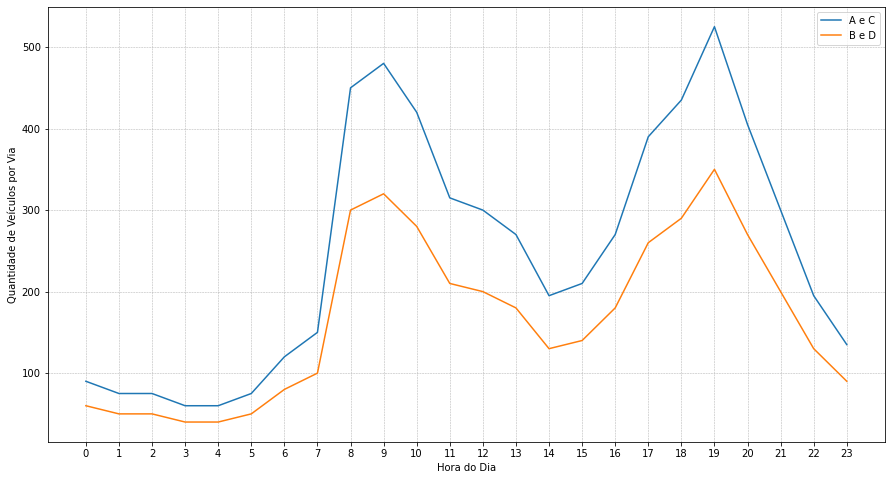

In [9]:
# Quantidade de veículos por via

scale = 1
plt_data = {
    'hora': [],
    'volume3vias': [],
    'volume2vias': [],
}

for hora in range(0, 24):
    if hora == 0:
        scale = 0.6
    elif hora == 1 or hora == 2:
        scale = 0.5
    elif hora == 3 or hora == 4:
        scale = 0.4
    elif hora == 5:
        scale = 0.5
    elif hora == 6:
        scale = 0.8
    elif hora == 7:
        scale = 1.0
    elif hora == 8:
        scale = 3
    elif hora == 9:
        scale = 3.2
    elif hora == 10:
        scale = 2.8
    elif hora == 11:
        scale = 2.1
    elif hora == 12:
        scale = 2
    elif hora == 13:
        scale = 1.8
    elif hora == 14:
        scale = 1.3
    elif hora == 15:
        scale = 1.4
    elif hora == 16:
        scale = 1.8
    elif hora == 17:
        scale = 2.6
    elif hora == 18:
        scale = 2.9
    elif hora == 19:
        scale = 3.5
    elif hora == 20:
        scale = 2.7
    elif hora == 21:
        scale = 2
    elif hora == 22:
        scale = 1.3
    elif hora == 23:
        scale = 0.9
    
    plt_data['hora'].append(hora)
    plt_data['volume3vias'].append((100 + 20 + 15 + 15) * scale)
    plt_data['volume2vias'].append((50 + 20 + 15 + 15) * scale)


plt.figure(figsize=(15, 8))
plt.xlabel('Hora do Dia')
plt.ylabel('Quantidade de Veículos por Via')
plt.plot(plt_data['hora'], plt_data['volume3vias'], label='A e C')
plt.plot(plt_data['hora'], plt_data['volume2vias'], label='B e D')
plt.legend()
plt.grid(linestyle='--', linewidth=0.5)
plt.xticks(plt_data['hora'])
plt.show()


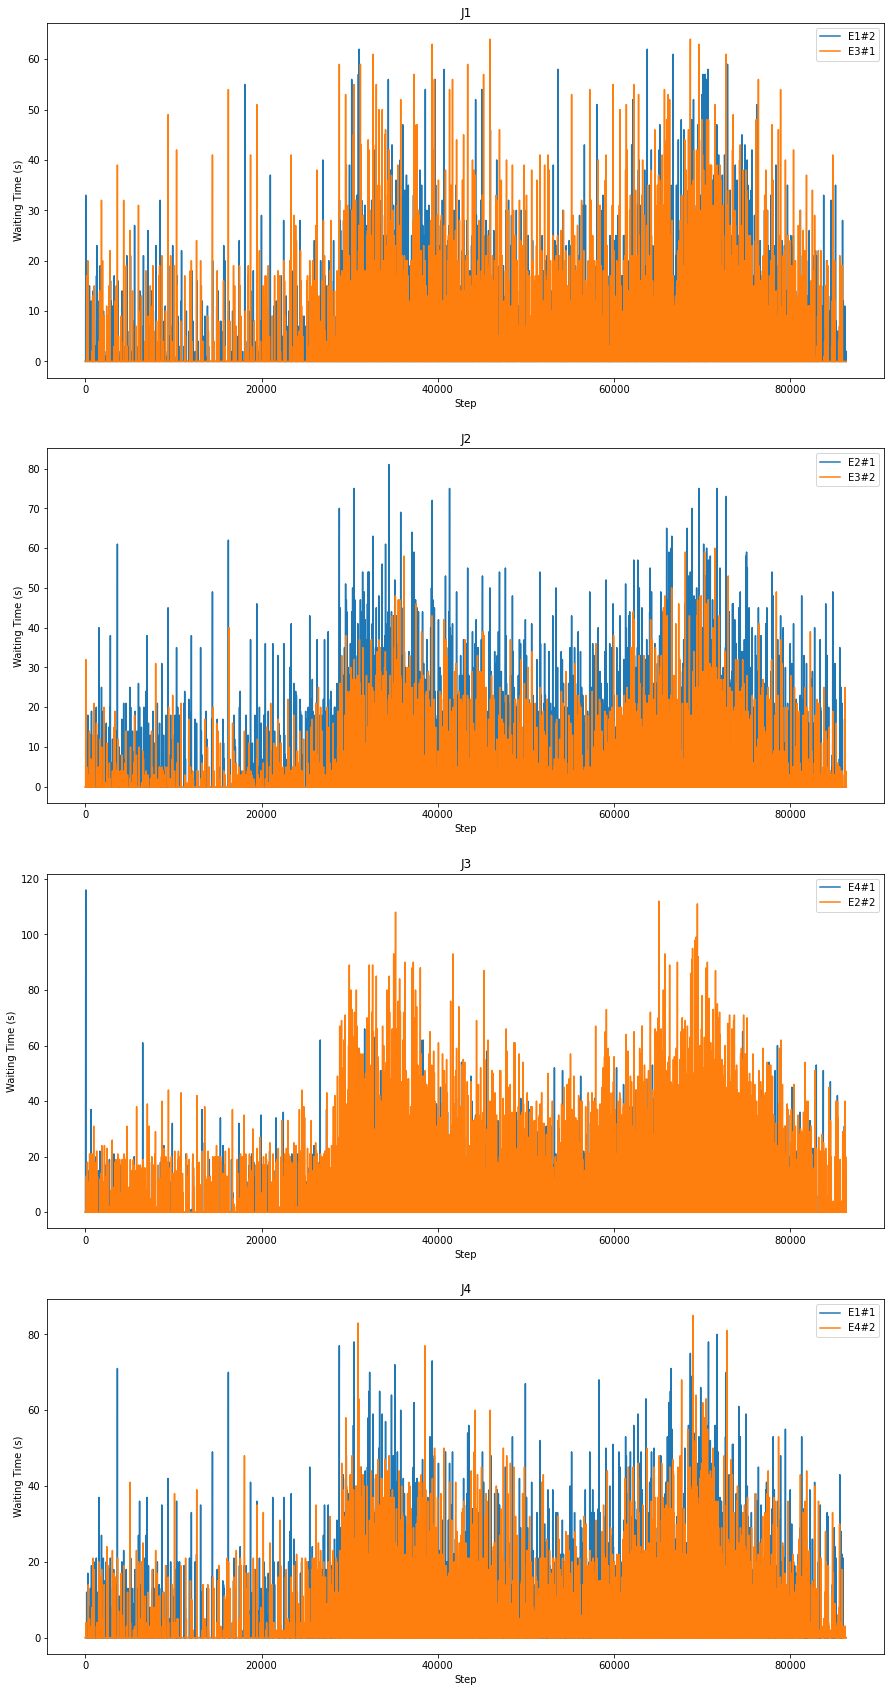

In [38]:
# Total Waiting Time By Traffic Light

with open('arquivos/fixedTime_18.json') as json_file:
    simulation_data = json.load(json_file)

plt.figure(figsize=(15, 30))

steps = [_['step'] for _ in simulation_data['data']]

traffic_lights_count = len(simulation_data['traffic_lights'])

for idx, traffic_light in enumerate(simulation_data['traffic_lights']):

    plt.subplot(traffic_lights_count, 1, idx + 1)
    plt.title(traffic_light['id'])
    plt.xlabel('Step')
    plt.ylabel('Waiting Time (s)')

    traffic_light_data = {}

    for edge in traffic_light['controlled_edges']:
        traffic_light_data[edge['id']] = []

    for step in simulation_data['data']:
        for step_traffic_light in step['traffic_lights']:
            if step_traffic_light['id'] == traffic_light['id']:
                for controlled_edge in step_traffic_light['controlled_edges']:
                    traffic_light_data[controlled_edge['id']].append(
                        controlled_edge['waiting_time'])
    
    for edge in traffic_light['controlled_edges']:
        plt.plot(steps, traffic_light_data[edge['id']], label=edge['id'])
    plt.legend()

plt.show()


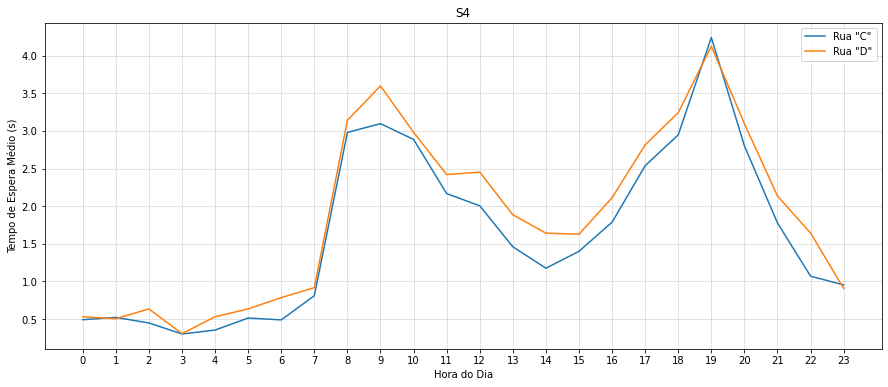

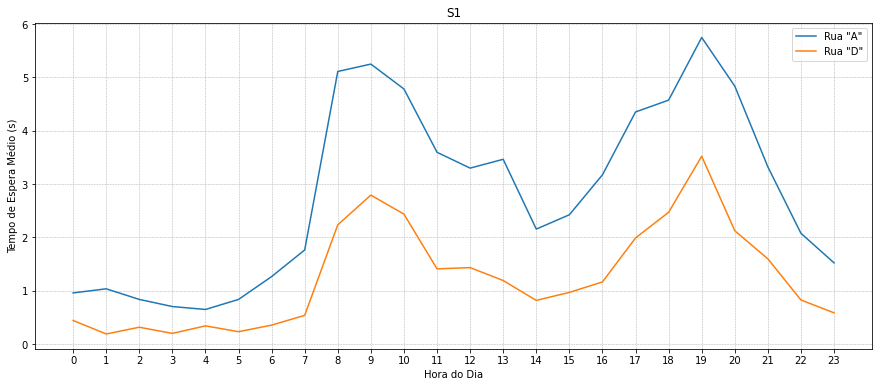

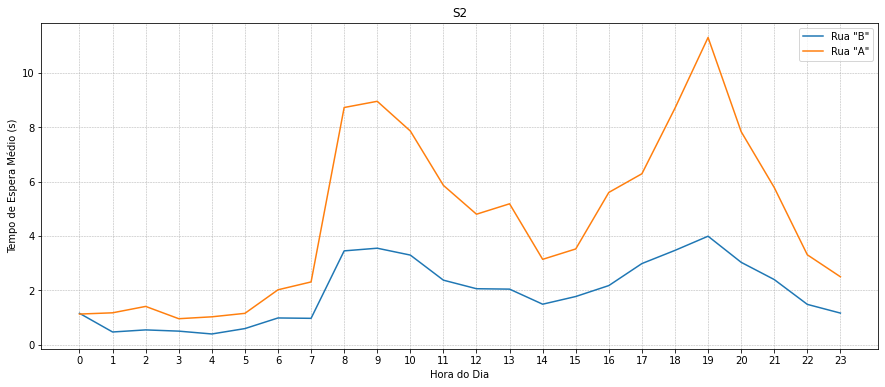

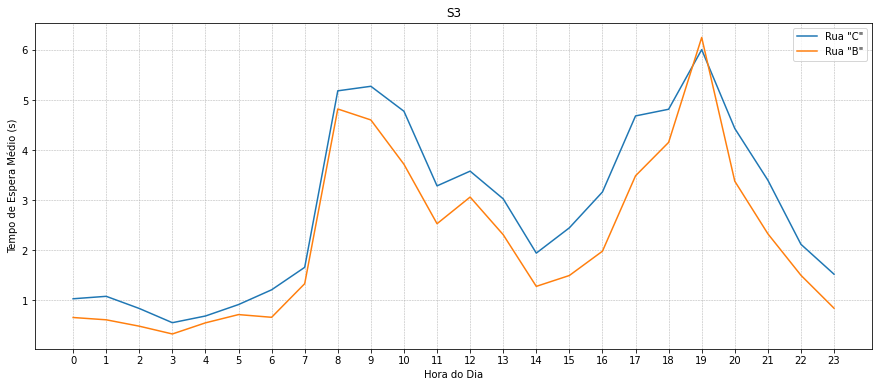

In [39]:
# Total Waiting Time By Traffic Light

with open('arquivos/fixedTime_18.json') as json_file:
    simulation_data = json.load(json_file)


steps = [_['step'] for _ in simulation_data['data']]

traffic_lights_count = len(simulation_data['traffic_lights'])

for idx, traffic_light in enumerate(simulation_data['traffic_lights']):

    plt.figure(figsize=(15, 6))
    
    title = 'S1' if traffic_light['id'] == 'J2' else 'S2' if traffic_light['id'] == 'J3' else 'S3' if traffic_light['id'] == 'J4' else 'S4' if traffic_light['id'] == 'J1' else ''

    plt.title(title)
    plt.xlabel('Hora do Dia')
    plt.ylabel('Tempo de Espera Médio (s)')

    traffic_light_data = {}

    for edge in traffic_light['controlled_edges']:
        traffic_light_data[edge['id']] = []

    for step in simulation_data['data']:
        for step_traffic_light in step['traffic_lights']:
            if step_traffic_light['id'] == traffic_light['id']:
                for controlled_edge in step_traffic_light['controlled_edges']:
                    traffic_light_data[controlled_edge['id']].append(
                        controlled_edge['waiting_time'])

    for edge in traffic_light['controlled_edges']:
        # by hour
        hour_data = []
        for hour in range(0, 24):
            hour_data.append(
                sum(traffic_light_data[edge['id']][hour * 3600:(hour + 1) * 3600])
                / len(traffic_light_data[edge['id']][hour * 3600:(hour + 1) * 3600])
            )
        
        label = ''

        if edge['id'].startswith('E2'):
            label = 'A'
        elif edge['id'].startswith('E4'):
            label = 'B'
        elif edge['id'].startswith('E1'):
            label = 'C'
        elif edge['id'].startswith('E3'):
            label = 'D'

        plt.plot(range(0, 24), hour_data, label=f'Rua "{label}"')

    plt.xticks(range(0, 24))
    plt.legend()
    plt.grid(linestyle='--', linewidth=0.5)
    plt.show()


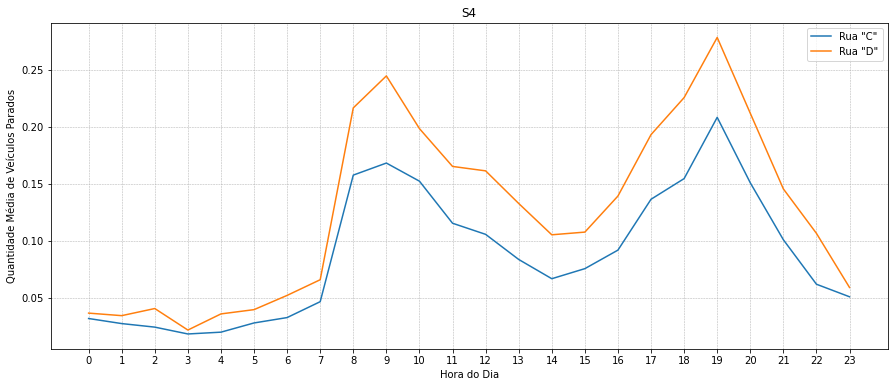

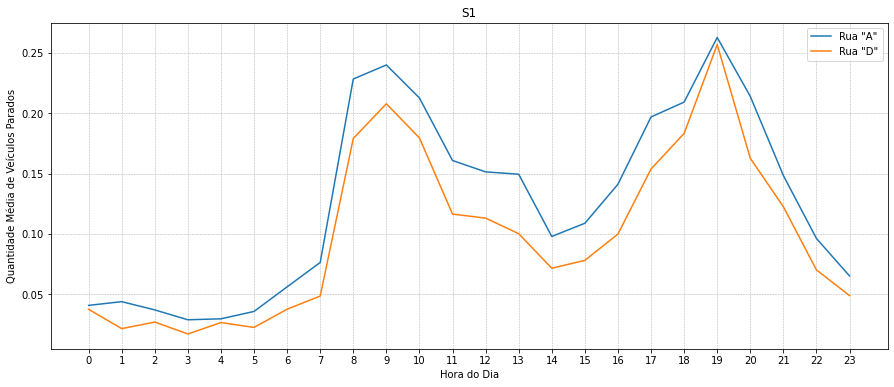

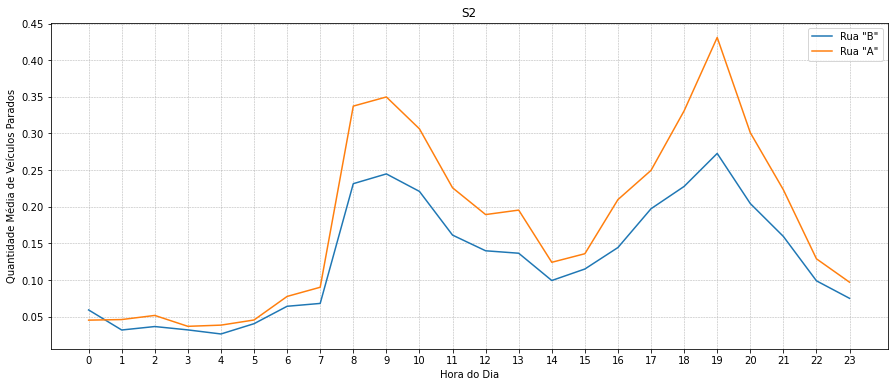

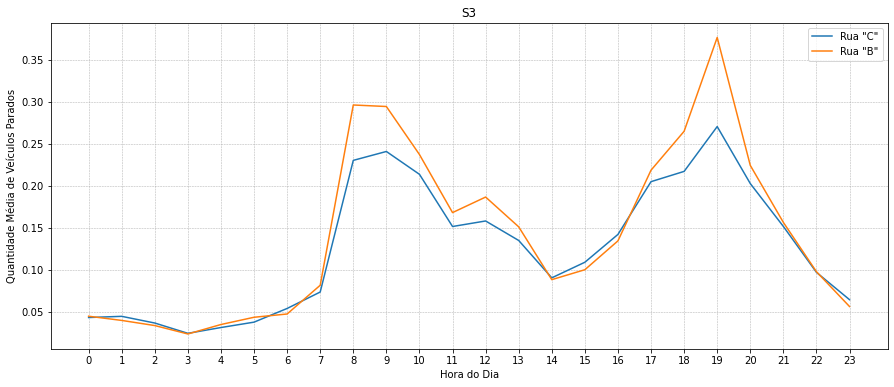

In [37]:
# Avg Queue Length By Traffic Light

with open('arquivos/fixedTime_18.json') as json_file:
    simulation_data = json.load(json_file)


steps = [_['step'] for _ in simulation_data['data']]

traffic_lights_count = len(simulation_data['traffic_lights'])

for idx, traffic_light in enumerate(simulation_data['traffic_lights']):

    plt.figure(figsize=(15, 6))

    title = 'S1' if traffic_light['id'] == 'J2' else 'S2' if traffic_light[
        'id'] == 'J3' else 'S3' if traffic_light['id'] == 'J4' else 'S4' if traffic_light['id'] == 'J1' else ''

    plt.title(title)
    plt.xlabel('Hora do Dia')
    plt.ylabel('Quantidade Média de Veículos Parados')

    traffic_light_data = {}

    for edge in traffic_light['controlled_edges']:
        traffic_light_data[edge['id']] = []

    for step in simulation_data['data']:
        for step_traffic_light in step['traffic_lights']:
            if step_traffic_light['id'] == traffic_light['id']:
                for controlled_edge in step_traffic_light['controlled_edges']:
                    traffic_light_data[controlled_edge['id']].append(
                        controlled_edge['avg_queue_length'])

    for edge in traffic_light['controlled_edges']:
        # by hour
        hour_data = []
        for hour in range(0, 24):
            hour_data.append(
                sum(traffic_light_data[edge['id']]
                    [hour * 3600:(hour + 1) * 3600])
                / len(traffic_light_data[edge['id']][hour * 3600:(hour + 1) * 3600])
            )

        label = ''

        if edge['id'].startswith('E2'):
            label = 'A'
        elif edge['id'].startswith('E4'):
            label = 'B'
        elif edge['id'].startswith('E1'):
            label = 'C'
        elif edge['id'].startswith('E3'):
            label = 'D'

        plt.plot(range(0, 24), hour_data, label=f'Rua "{label}"')

    plt.xticks(range(0, 24))
    plt.legend()
    plt.grid(linestyle='--', linewidth=0.5)
    plt.show()


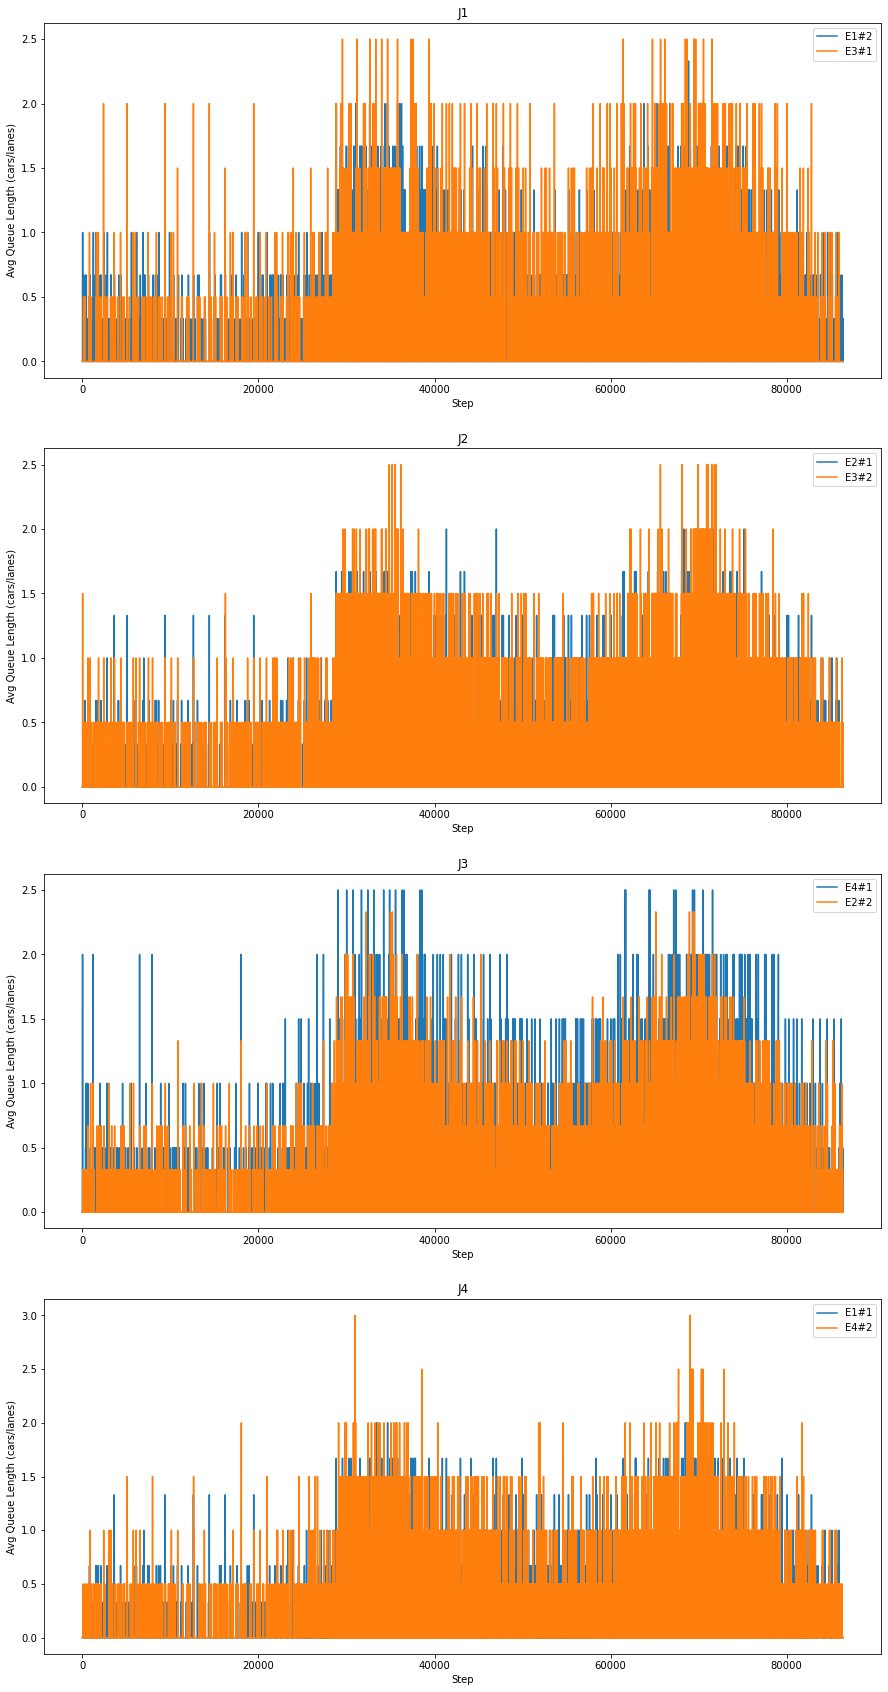

In [28]:
# Avg Queue Length By Traffic Light

plt.figure(figsize=(15, 30))

steps = [_['step'] for _ in simulation_data['data']]

traffic_lights_count = len(simulation_data['traffic_lights'])

for idx, traffic_light in enumerate(simulation_data['traffic_lights']):

    plt.subplot(traffic_lights_count, 1, idx + 1)
    plt.title(traffic_light['id'])
    plt.xlabel('Step')
    plt.ylabel('Avg Queue Length (cars/lanes)')

    traffic_light_data = {}

    for edge in traffic_light['controlled_edges']:
        traffic_light_data[edge['id']] = []

    for step in simulation_data['data']:
        for step_traffic_light in step['traffic_lights']:
            if step_traffic_light['id'] == traffic_light['id']:
                for controlled_edge in step_traffic_light['controlled_edges']:
                    traffic_light_data[controlled_edge['id']].append(
                        controlled_edge['avg_queue_length'])

    for edge in traffic_light['controlled_edges']:
        plt.plot(steps, traffic_light_data[edge['id']], label=edge['id'])
    plt.legend()

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


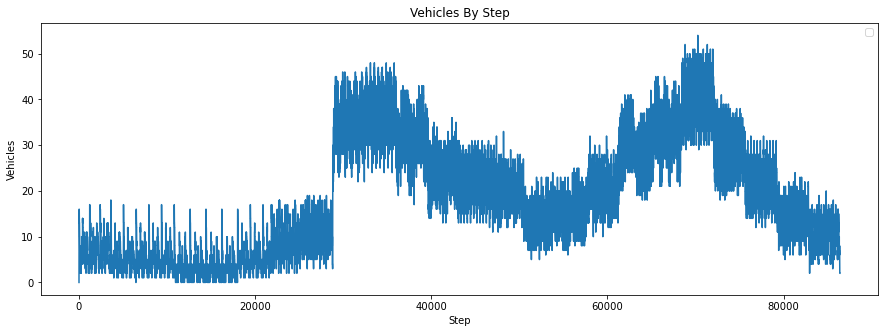

In [131]:
# Vehicles By Step

plt.figure(figsize=(15, 5))

steps = [_['step'] for _ in simulation_data['stats']['step']]
vehicles = [_['vehicles'] for _ in simulation_data['stats']['step']]

plt.title('Vehicles By Step')
plt.xlabel('Step')
plt.ylabel('Vehicles')

plt.plot(steps, vehicles)
plt.legend()

plt.show()
